In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
#import seaborn as sns
from datetime import datetime
#import scipy.stats as stats
#import statsmodels.api as sm
import re
from shapely.geometry import Point
import geopandas as gpd
#import folium
#from folium.plugins import MarkerCluster
#from folium.plugins import FastMarkerCluster
from ipywidgets import interact, interactive, fixed, interact_manual
import plotly.express as px
import plotly.graph_objects as go
from plotly.colors import n_colors
import chart_studio
import chart_studio.plotly as py
import plotly.figure_factory as ff

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [5]:
tracts_rankings = pd.read_csv('../data/tracts_rankings.csv')

In [6]:
tracts_rankings.head()

,GEOID,geometry,house_pct_change_rank,rental_price_pct_change_rank,white_pct_change_rank,bach_pct_change_rank,renter_pct_change_rank,median_hhi_pct_change_rank,poverty_pct_change_rank,total_rank
0,47037015625,"POLYGON ((-86.65754299999999 36.119373, -86.65...",31.0,29.0,71.0,141.0,127.0,110.0,99.0,104.0
1,47037016000,"POLYGON ((-86.772654 36.149871, -86.769481 36....",1.0,37.0,4.0,6.0,136.0,2.0,53.0,8.0
2,47037017300,"POLYGON ((-86.75090899999999 36.120388, -86.75...",1.0,37.0,21.0,2.0,104.0,43.0,48.0,11.0
3,47037018409,"POLYGON ((-86.98224599999999 36.075294, -86.98...",73.0,37.0,75.0,75.0,75.0,74.0,75.0,150.0
4,47037019106,"POLYGON ((-86.74414299999999 36.043424, -86.74...",73.0,123.0,113.0,70.0,83.0,116.0,120.0,138.0


In [370]:
airbnb = pd.read_csv('../data/airbnb_df.csv')

In [371]:
airbnb.head()

,listing_id,comments_concatenated,name,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,listing_url,description,neighborhood_overview,host_since,host_listings_count,property_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights_avg_ntm,maximum_nights_avg_ntm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,zip_code,GEOID,house_price_2021-01-31,house_pct_change,rentals_2021-01-31,rental_price_pct_change,new_restaurants,available_beer,str_permits_2020,str_permits_growth,crimes,total_pop_2010,total_pop_2019,total_pop_change,total_pop_pct_change,pop_over25_2010,pop_over25_2019,pop_over25_change,pop_over25_pcg_change,total_households_2010,total_households_2019,total_households_change,total_households_pct_change,white_pct_2010,white_pct_2019,white_value_change,white_pct_change,bach_pct_2010,bach_pct_2019,bach_value_change,bach_pct_change,rent_pct_2010,rent_pct_2019,rent_value_change,renter_pct_change,median_hhi_2010,median_hhi_2019,median_hhi_value_change,median_hhi_pct_change,poverty_pct_2010,poverty_pct_2019,poverty_value_change,poverty_pct_change
0,6422,I can't say enough about how wonderful it was ...,Nashville Charm,12172,36.17315,-86.73581,40,30,674,4.69,1,267,https://www.airbnb.com/rooms/6422,30 day or more rental during COVID. Show COVID...,Historic East Nashville is home to many new an...,2009-04-03,0.0,Private room in house,2,1 private bath,2.0,3.0,"[""Hair dryer"", ""Bathtub"", ""Lock on bedroom doo...",30.0,365.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,37206.0,4.703701e+10,412476.0,38.31,NaN,NaN,1.0,2.0,114.0,114.0,1165.0,2544.0,2100.0,-444.0,-0.174528,1703.0,1639.0,-64.0,-0.037581,1140.0,926.0,-214.0,-0.187719,0.657626,0.940952,0.283327,0.430833,0.408691,0.585723,0.177032,0.433170,0.320175,0.240821,-0.079355,-0.247848,46000.0,91643.0,45643.0,0.992239,10.6,10.2,-0.4,-0.037736
1,25613,Nell and Michael made my stay pleasant and eas...,Room in Historic East Nashville Craftsman Home,95811,36.17826,-86.74162,75,2,510,3.87,1,63,https://www.airbnb.com/rooms/25613,Serve up some sweet sounds on the piano and wi...,This home is in a walkable neighborhood with i...,2010-03-18,1.0,Private room in house,2,1 private bath,1.0,1.0,"[""Hair dryer"", ""Carbon monoxide alarm"", ""Air c...",2.0,1125.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,37206.0,4.703701e+10,412476.0,38.31,NaN,NaN,3.0,12.0,101.0,101.0,1048.0,2485.0,2525.0,40.0,0.016097,1895.0,1938.0,43.0,0.022691,1234.0,1092.0,-142.0,-0.115073,0.889738,0.930297,0.040559,0.045585,0.472296,0.742002,0.269707,0.571055,0.416532,0.274725,-0.141806,-0.340446,52372.0,116800.0,64428.0,1.230199,21.6,4.1,-17.5,-0.810185
2,136015,"Very relaxing, beautiful property, and warm / ...",Apart. on the Ridge near Opryland,666322,36.19464,-86.67195,103,30,50,0.43,2,190,https://www.airbnb.com/rooms/136015,Fantastic View! Overlooks farms and is on the ...,Dead end street with great neighbors!,2011-06-05,4.0,Entire apartment,2,1 bath,1.0,1.0,"[""Fire extinguisher"", ""Wifi"", ""Dryer"", ""Washer...",30.0,1125.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,37214.0,4.703702e+10,278031.0,65.43,1581.0,22.18,9.0,112.0,48.0,48.0,4429.0,5411.0,6024.0,613.0,0.113288,4451.0,4970.0,519.0,0.116603,2566.0,2714.0,148.0,0.057677,0.781186,0.760458,-0.020728,-0.026534,0.365311,0.430986,0.065675,0.179778,0.120811,0.179071,0.058261,0.482250,53590.0,68532.0,14942.0,0.278821,3.6,6.9,3.3,0.916667
3,258817,Diana is such a gracious hostess. She has a b...,ButterflyRoom-private bath- open Jan 26,22296,36.16249,-86.58988,27,30,96,0.86,7,364,https://www.airbnb.com/rooms/258817,Morningstar House! Extended stay - 3+ months- ...,"I'm very near the Percy Priest Lake, natural ...",2009-06-19,16.0,Private room in house,2,1 private bath,1.0,2.0,"[""Hair dryer"", ""Air conditioning"", ""Smoke alar...",30.0,365.0,95.0,10.0,9.0,10.0,10.0,9.0,9.0,37076.0,4

In [372]:
# Keep only features that I will use to identify gentrification
gentrification_features = ['GEOID', 'house_pct_change', 'rental_price_pct_change', 'white_pct_change', 
                           'bach_pct_change', 'renter_pct_change', 'median_hhi_pct_change', 'poverty_pct_change']

In [373]:
gentrification_df = airbnb[gentrification_features].drop_duplicates('GEOID')

In [374]:
gentrification_df = gentrification_df[gentrification_df['GEOID'].notna()]

In [375]:
gentrification_df.head()

,GEOID,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
0,4.703701e+10,38.31,NaN,0.430833,0.433170,-0.247848,0.992239,-0.037736
1,4.703701e+10,38.31,NaN,0.045585,0.571055,-0.340446,1.230199,-0.810185
2,4.703702e+10,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667
3,4.703702e+10,51.53,NaN,-0.176354,-0.037855,-0.028681,0.122428,1.088235
7,4.703702e+10,38.31,NaN,0.049556,0.387603,0.112385,0.720376,-0.228758


In [376]:
gentrification_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 4825
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   GEOID                    150 non-null    float64
 1   house_pct_change         149 non-null    float64
 2   rental_price_pct_change  87 non-null     float64
 3   white_pct_change         149 non-null    float64
 4   bach_pct_change          149 non-null    float64
 5   renter_pct_change        148 non-null    float64
 6   median_hhi_pct_change    147 non-null    float64
 7   poverty_pct_change       148 non-null    float64
dtypes: float64(8)
memory usage: 10.5 KB


In [377]:
gentrification_df.shape

(150, 8)

In [378]:
# Create list of features that need NaNs filled by medians
medians = ['house_pct_change', 'rental_price_pct_change', 'white_pct_change', 'bach_pct_change', 'renter_pct_change', 
           'median_hhi_pct_change', 'poverty_pct_change']

In [379]:
gentrification_df[medians] = gentrification_df[medians].fillna(gentrification_df.median())

In [380]:
gentrification_df.head()

,GEOID,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
0,4.703701e+10,38.31,18.35,0.430833,0.433170,-0.247848,0.992239,-0.037736
1,4.703701e+10,38.31,18.35,0.045585,0.571055,-0.340446,1.230199,-0.810185
2,4.703702e+10,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667
3,4.703702e+10,51.53,18.35,-0.176354,-0.037855,-0.028681,0.122428,1.088235
7,4.703702e+10,38.31,18.35,0.049556,0.387603,0.112385,0.720376,-0.228758


In [381]:
gentrification_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 4825
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   GEOID                    150 non-null    float64
 1   house_pct_change         150 non-null    float64
 2   rental_price_pct_change  150 non-null    float64
 3   white_pct_change         150 non-null    float64
 4   bach_pct_change          150 non-null    float64
 5   renter_pct_change        150 non-null    float64
 6   median_hhi_pct_change    150 non-null    float64
 7   poverty_pct_change       150 non-null    float64
dtypes: float64(8)
memory usage: 10.5 KB


In [382]:
gentrification_df.describe()

,GEOID,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
count,1.500000e+02,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,4.703702e+10,53.128067,18.353067,0.774029,0.444372,0.210394,0.413937,inf
std,7.880766e+04,13.602770,4.888480,5.382851,0.742882,0.515318,0.386433,NaN
min,4.703701e+10,31.110000,7.730000,-0.413595,-0.377566,-0.369817,-0.180354,-0.863874
25%,4.703701e+10,40.190000,18.350000,-0.091308,0.031430,-0.039293,0.163609,-0.183005
50%,4.703702e+10,51.350000,18.350000,-0.002333,0.184014,0.080751,0.341001,0.224314
75%,4.703702e+10,65.417500,18.350000,0.151780,0.588447,0.251190,0.581724,1.078472
max,4.703798e+10,74.310000,29.300000,64.071146,4.396047,2.792779,2.454128,inf


In [383]:
gentrification_df['GEOID'] = gentrification_df['GEOID'].astype(int).astype(str)

In [384]:
gentrification_df = gentrification_df.set_index('GEOID')

In [385]:
gentrification_df.head()

,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
GEOID,,,,,,,
47037012200,38.31,18.35,0.430833,0.433170,-0.247848,0.992239,-0.037736
47037012100,38.31,18.35,0.045585,0.571055,-0.340446,1.230199,-0.810185
47037015300,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667
47037015610,51.53,18.35,-0.176354,-0.037855,-0.028681,0.122428,1.088235
47037019200,38.31,18.35,0.049556,0.387603,0.112385,0.720376,-0.228758


In [386]:
gentrification_bools = gentrification_df.copy()

In [387]:
gentrification_bools['house_pct_change_bool'] = np.where(
    gentrification_bools['house_pct_change'] > gentrification_bools['house_pct_change'].quantile(0.80), True, False)

gentrification_bools['rental_price_pct_change_bool'] = np.where(
    gentrification_bools['rental_price_pct_change'] > gentrification_bools['rental_price_pct_change'].quantile(0.80), True, False)

gentrification_bools['white_pct_change_bool'] = np.where(
    gentrification_bools['white_pct_change'] > gentrification_bools['white_pct_change'].quantile(0.80), True, False)

gentrification_bools['bach_pct_change_bool'] = np.where(
    gentrification_bools['bach_pct_change'] > gentrification_bools['bach_pct_change'].quantile(0.80), True, False)

gentrification_bools['renter_pct_change_bool'] = np.where(
    gentrification_bools['renter_pct_change'] < gentrification_bools['renter_pct_change'].quantile(0.20), True, False)

gentrification_bools['median_hhi_pct_change_bool'] = np.where(
    gentrification_bools['median_hhi_pct_change'] > gentrification_bools['median_hhi_pct_change'].quantile(0.80), True, False)

gentrification_bools['poverty_pct_change_bool'] = np.where(
    gentrification_bools['poverty_pct_change'] < gentrification_bools['poverty_pct_change'].quantile(0.20), True, False)

In [388]:
gentrification_bools.head()

,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change,house_pct_change_bool,rental_price_pct_change_bool,white_pct_change_bool,bach_pct_change_bool,renter_pct_change_bool,median_hhi_pct_change_bool,poverty_pct_change_bool
GEOID,,,,,,,,,,,,,,
47037012200,38.31,18.35,0.430833,0.433170,-0.247848,0.992239,-0.037736,False,False,True,False,True,True,False
47037012100,38.31,18.35,0.045585,0.571055,-0.340446,1.230199,-0.810185,False,False,False,False,True,True,True
47037015300,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667,False,False,False,False,False,False,False
47037015610,51.53,18.35,-0.176354,-0.037855,-0.028681,0.122428,1.088235,False,False,False,False,False,False,False
47037019200,38.31,18.35,0.049556,0.387603,0.112385,0.720376,-0.228758,False,False,False,False,False,True,False


In [389]:
gentrification_bools.columns

Index(['house_pct_change', 'rental_price_pct_change', 'white_pct_change', 'bach_pct_change', 'renter_pct_change', 'median_hhi_pct_change', 'poverty_pct_change', 'house_pct_change_bool', 'rental_price_pct_change_bool', 'white_pct_change_bool', 'bach_pct_change_bool', 'renter_pct_change_bool', 'median_hhi_pct_change_bool', 'poverty_pct_change_bool'], dtype='object')

In [390]:
gentrification_counts = gentrification_bools[['house_pct_change_bool', 'rental_price_pct_change_bool', 
                                           'white_pct_change_bool', 'bach_pct_change_bool', 
                                           'renter_pct_change_bool', 'median_hhi_pct_change_bool', 
                                           'poverty_pct_change_bool']]

In [391]:
gentrification_counts['total'] = gentrification_counts.sum(axis=1)

## Visualize census tracts that fit each feature's highest percentiles

In [392]:
tracts = gpd.read_file('../data/cb_2018_47_tract_500k.shp')

In [393]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,47,093,001900,1400000US47093001900,47093001900,19,CT,2203514,13116,"POLYGON ((-83.90062 35.99202, -83.88800 36.000..."
1,47,093,003902,1400000US47093003902,47093003902,39.02,CT,3451146,0,"POLYGON ((-83.98563 36.00119, -83.98152 36.004..."
2,47,093,004404,1400000US47093004404,47093004404,44.04,CT,5964584,11451,"POLYGON ((-84.03695 35.93007, -84.02293 35.933..."
3,47,093,005708,1400000US47093005708,47093005708,57.08,CT,3557676,38601,"POLYGON ((-84.11800 35.86332, -84.11387 35.866..."
4,47,093,006103,1400000US47093006103,47093006103,61.03,CT,6437142,0,"POLYGON ((-84.07012 36.02888, -84.06820 36.031..."


In [394]:
tracts['FIPS'] = tracts.STATEFP + tracts.COUNTYFP

In [395]:
tracts = tracts[tracts['FIPS']=='47037'][['GEOID', 'geometry']]

In [396]:
#1: Total Claims vs ODs, colored by percent of claims by selected opioid (all graphs use same color choice)
# Problem - Does not show significant results. 

@interact(feature = gentrification_counts.columns.to_list()[-9:-1])

def gentrification_map(feature) :
    tracts_visual = tracts.copy()
    
    visual_tracts = gentrification_counts[gentrification_counts[feature]==True].index.to_list()
    
    tracts_visual['visual'] = np.where(tracts.GEOID.isin(visual_tracts), True, False)
    
   # leg_kwds = {'title': 'Changing Neighborhoods', 'loc': 'upper left', 
   #         'bbox_to_anchor': (1, 1.03), 'ncol': 1}

    tracts_visual.plot(column = 'visual',
            figsize=(10, 10),
            edgecolor = 'black',
            cmap = 'Set2');

interactive(children=(Dropdown(description='feature', options=('house_pct_change_bool', 'rental_price_pct_chan…

In [397]:
gentrification_counts.head()

,house_pct_change_bool,rental_price_pct_change_bool,white_pct_change_bool,bach_pct_change_bool,renter_pct_change_bool,median_hhi_pct_change_bool,poverty_pct_change_bool,total
GEOID,,,,,,,,
47037012200,False,False,True,False,True,True,False,3
47037012100,False,False,False,False,True,True,True,3
47037015300,False,False,False,False,False,False,False,0
47037015610,False,False,False,False,False,False,False,0
47037019200,False,False,False,False,False,True,False,1


In [398]:
tracts_booleans = tracts.merge(gentrification_counts.reset_index()[['GEOID', 'total']], on='GEOID', how='left')

In [399]:
tracts_booleans['total'] = tracts_booleans['total'].fillna(0)

In [400]:
tracts_booleans.head()

,GEOID,geometry,total
0,47037015625,"POLYGON ((-86.65754 36.11937, -86.65558 36.122...",0.0
1,47037016000,"POLYGON ((-86.77265 36.14987, -86.76948 36.151...",4.0
2,47037017300,"POLYGON ((-86.75091 36.12039, -86.75051 36.121...",3.0
3,47037018409,"POLYGON ((-86.98225 36.07529, -86.98171 36.075...",0.0
4,47037019106,"POLYGON ((-86.74414 36.04342, -86.74375 36.047...",0.0


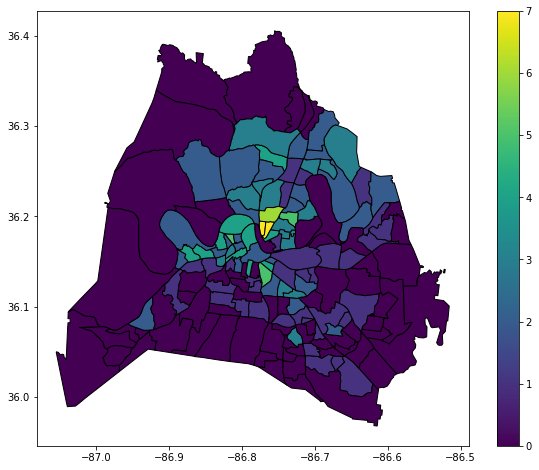

In [401]:
tracts_booleans.plot(column = 'total',
            figsize=(10, 8),
            legend=True,
            edgecolor = 'black');

## Visualize each tract by percentile

In [402]:
gentrification_df.head()

,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
GEOID,,,,,,,
47037012200,38.31,18.35,0.430833,0.433170,-0.247848,0.992239,-0.037736
47037012100,38.31,18.35,0.045585,0.571055,-0.340446,1.230199,-0.810185
47037015300,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667
47037015610,51.53,18.35,-0.176354,-0.037855,-0.028681,0.122428,1.088235
47037019200,38.31,18.35,0.049556,0.387603,0.112385,0.720376,-0.228758


In [403]:
gentrification_df.columns

Index(['house_pct_change', 'rental_price_pct_change', 'white_pct_change', 'bach_pct_change', 'renter_pct_change', 'median_hhi_pct_change', 'poverty_pct_change'], dtype='object')

In [404]:
gentrification_percents = gentrification_df[['house_pct_change', 'rental_price_pct_change', 'white_pct_change', 
                                             'bach_pct_change', 'renter_pct_change', 'median_hhi_pct_change', 
                                             'poverty_pct_change']]

In [405]:
gentrification_percents.head(1)

,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
GEOID,,,,,,,
47037012200,38.31,18.35,0.430833,0.43317,-0.247848,0.992239,-0.037736


In [406]:
#1: Total Claims vs ODs, colored by percent of claims by selected opioid (all graphs use same color choice)
# Problem - Does not show significant results. 

@interact(feature = gentrification_percents.columns.to_list())

def gentrification_map(feature) :
    percents_map = tracts.merge(gentrification_percents.reset_index()[['GEOID', feature]], on='GEOID', how='left')
    percents_map[feature] = percents_map[feature].fillna(percents_map[feature].median())
    
    test_map = px.choropleth(percents_map, 
                        geojson=percents_map.geometry,
                        locations=percents_map.index, 
                        color=feature,
                        color_continuous_scale="Viridis"#,
                        #range_color=(0, 12),
                        #labels={'unemp':'unemployment rate'}
                        )
    test_map.update_geos(fitbounds="locations", visible=False)
    
    test_map.show()

    #test_map.write_html("/Users/mattparker/Documents/nss_projects/airbnb-sentiments/notebooks/test_map.html")
    #py.plot(test_map, filename = 'test_map', auto_open=True)

interactive(children=(Dropdown(description='feature', options=('house_pct_change', 'rental_price_pct_change', …

## Determine Gentrification by Ranking

In [407]:
gentrification_df.head()

,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change
GEOID,,,,,,,
47037012200,38.31,18.35,0.430833,0.433170,-0.247848,0.992239,-0.037736
47037012100,38.31,18.35,0.045585,0.571055,-0.340446,1.230199,-0.810185
47037015300,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667
47037015610,51.53,18.35,-0.176354,-0.037855,-0.028681,0.122428,1.088235
47037019200,38.31,18.35,0.049556,0.387603,0.112385,0.720376,-0.228758


In [408]:
gentrification_ranks = gentrification_df.copy()

In [409]:
gentrification_ranks['house_pct_change_rank'] = gentrification_ranks['house_pct_change'].rank(ascending=True, method='dense').astype(int)
gentrification_ranks['rental_price_pct_change_rank'] = gentrification_ranks['rental_price_pct_change'].rank(ascending=True, method='dense').astype(int)
gentrification_ranks['white_pct_change_rank'] = gentrification_ranks['white_pct_change'].rank(ascending=True, method='dense').astype(int)
gentrification_ranks['bach_pct_change_rank'] = gentrification_ranks['bach_pct_change'].rank(ascending=True, method='dense').astype(int)
gentrification_ranks['renter_pct_change_rank'] = gentrification_ranks['renter_pct_change'].rank(ascending=False, method='dense').astype(int)
gentrification_ranks['median_hhi_pct_change_rank'] = gentrification_ranks['median_hhi_pct_change'].rank(ascending=True, method='dense').astype(int)
gentrification_ranks['poverty_pct_change_rank'] = gentrification_ranks['poverty_pct_change'].rank(ascending=False, method='dense').astype(int)

In [410]:
gentrification_ranks.head()

,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change,house_pct_change_rank,rental_price_pct_change_rank,white_pct_change_rank,bach_pct_change_rank,renter_pct_change_rank,median_hhi_pct_change_rank,poverty_pct_change_rank
GEOID,,,,,,,,,,,,,,
47037012200,38.31,18.35,0.430833,0.433170,-0.247848,0.992239,-0.037736,6,6,130,103,142,136,81
47037012100,38.31,18.35,0.045585,0.571055,-0.340446,1.230199,-0.810185,6,6,88,111,148,141,136
47037015300,65.43,22.18,-0.026534,0.179778,0.482250,0.278821,0.916667,17,7,58,74,19,67,33
47037015610,51.53,18.35,-0.176354,-0.037855,-0.028681,0.122428,1.088235,13,6,16,23,109,29,28
47037019200,38.31,18.35,0.049556,0.387603,0.112385,0.720376,-0.228758,6,6,89,98,64,123,102


In [411]:
gentrification_ranks.columns

Index(['house_pct_change', 'rental_price_pct_change', 'white_pct_change', 'bach_pct_change', 'renter_pct_change', 'median_hhi_pct_change', 'poverty_pct_change', 'house_pct_change_rank', 'rental_price_pct_change_rank', 'white_pct_change_rank', 'bach_pct_change_rank', 'renter_pct_change_rank', 'median_hhi_pct_change_rank', 'poverty_pct_change_rank'], dtype='object')

In [412]:
gentrification_rank_counts = gentrification_ranks[['house_pct_change_rank', 'rental_price_pct_change_rank', 
                                                   'white_pct_change_rank', 'bach_pct_change_rank', 
                                                   'renter_pct_change_rank', 'median_hhi_pct_change_rank', 
                                                   'poverty_pct_change_rank']]

In [413]:
gentrification_rank_counts['total'] = gentrification_rank_counts.sum(axis=1)

In [414]:
gentrification_rank_counts['total_rank'] = gentrification_rank_counts['total'].rank(
    ascending=True, method='dense').astype(int)

In [415]:
gentrification_rank_counts

,house_pct_change_rank,rental_price_pct_change_rank,white_pct_change_rank,bach_pct_change_rank,renter_pct_change_rank,median_hhi_pct_change_rank,poverty_pct_change_rank,total,total_rank
GEOID,,,,,,,,,
47037012200,6,6,130,103,142,136,81,604,120
47037012100,6,6,88,111,148,141,136,636,125
47037015300,17,7,58,74,19,67,33,275,33
47037015610,13,6,16,23,109,29,28,224,19
47037019200,6,6,89,98,64,123,102,488,104
...,...,...,...,...,...,...,...,...,...
47037018905,12,3,75,94,89,106,104,483,102
47037015629,14,6,39,110,82,52,32,335,57
47037010904,20,11,112,141,95,1,65,445,92


In [416]:
gentrification_rank_table = gentrification_rank_counts.drop(
    columns='total').sort_values(
    'total_rank', ascending=True).head(20)

In [417]:
gentrification_rank_table

,house_pct_change_rank,rental_price_pct_change_rank,white_pct_change_rank,bach_pct_change_rank,renter_pct_change_rank,median_hhi_pct_change_rank,poverty_pct_change_rank,total_rank
GEOID,,,,,,,,
47037018408,8,5,47,18,1,23,1,1
47037015617,16,6,61,29,13,4,18,2
47037018407,8,5,99,33,5,9,1,3
47037015630,14,6,36,92,7,3,8,4
47037015627,14,6,49,4,12,43,42,5
47037019117,14,6,125,9,3,5,14,6
47037015618,14,6,91,15,49,7,2,7
47037010802,18,6,27,57,27,12,45,8
47037018405,8,5,59,40,43,26,12,9


In [418]:
colors = n_colors('rgb(200, 15, 15)', 'rgb(0, 90, 220)', 150, colortype='rgb')

fig = go.Figure(data=[go.Table(
    #columnwidth = [15,170,15,35,35],
    header=dict(values=['<b>' + x + '</b>' for x in list(gentrification_rank_table.columns)],
                fill_color='#b9e2ff',
                line_color='darkslategray',
                align='center',
                font=dict(color='black', family="Lato", size=12),
                height=30
                ),
    cells=dict(values=[gentrification_rank_table[column] for column in gentrification_rank_table.columns],
               fill_color=[np.array(colors)[
                   gentrification_rank_table[column].to_numpy()] for column in gentrification_rank_table.columns],
               line_color='darkslategray',
               align='center',
               font=dict(color='black', family="Lato", size=20),
               height=30
               ))
])

# fig.update_layout(
# title="<b>Gentrification Feature Rank by Census Tract</b>",
# font=dict(
#     family="Lato",
#     size=18,
#     color="#000000"))

fig.show()

fig.write_html("/Users/mattparker/Documents/nss_projects/airbnb-sentiments/notebooks/feature_table.html")
py.plot(fig, filename = 'feature_table', auto_open=True)

'https://plotly.com/~matttparker/18/'

In [419]:
gentrification_rank_table.head(1)

,house_pct_change_rank,rental_price_pct_change_rank,white_pct_change_rank,bach_pct_change_rank,renter_pct_change_rank,median_hhi_pct_change_rank,poverty_pct_change_rank,total_rank
GEOID,,,,,,,,
47037018408,8,5,47,18,1,23,1,1


In [420]:
tracts_rankings = tracts.merge(gentrification_rank_counts.drop(columns='total').reset_index(), on='GEOID', how='left')

In [421]:
tracts_rankings

,GEOID,geometry,house_pct_change_rank,rental_price_pct_change_rank,white_pct_change_rank,bach_pct_change_rank,renter_pct_change_rank,median_hhi_pct_change_rank,poverty_pct_change_rank,total_rank
0,47037015625,"POLYGON ((-86.65754 36.11937, -86.65558 36.122...",17.0,7.0,79.0,10.0,24.0,41.0,41.0,16.0
1,47037016000,"POLYGON ((-86.77265 36.14987, -86.76948 36.151...",20.0,6.0,146.0,144.0,15.0,146.0,85.0,115.0
2,47037017300,"POLYGON ((-86.75091 36.12039, -86.75051 36.121...",20.0,6.0,129.0,148.0,47.0,105.0,90.0,112.0
3,47037018409,"POLYGON ((-86.98225 36.07529, -86.98171 36.075...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,47037019106,"POLYGON ((-86.74414 36.04342, -86.74375 36.047...",12.0,3.0,38.0,80.0,68.0,35.0,21.0,28.0
...,...,...,...,...,...,...,...,...,...,...
156,47037019004,"POLYGON ((-86.72632 36.07961, -86.72316 36.080...",12.0,3.0,7.0,77.0,70.0,98.0,82.0,64.0
157,47037010105,"POLYGON ((-86.88999 36.26282, -86.88760 36.265...",15.0,6.0,9.0,38.0,149.0,45.0,109.0,68.0
158,47037010904,"POLYGON ((-86.78634 36.23793, -86.78518 36.238...",20.0,11.0,112.0,141.0,95.0,1.0,65.0,92.0
159,47037018901,"POLYGON ((-86.76002 36.08151, -86.75783 36.083...",12.0,3.0,66.0,22.0,127.0,61.0,92.0,74.0


In [422]:
tracts_rankings['total_rank'] = tracts_rankings['total_rank'].fillna(0)

In [423]:
tracts_rankings.head()

,GEOID,geometry,house_pct_change_rank,rental_price_pct_change_rank,white_pct_change_rank,bach_pct_change_rank,renter_pct_change_rank,median_hhi_pct_change_rank,poverty_pct_change_rank,total_rank
0,47037015625,"POLYGON ((-86.65754 36.11937, -86.65558 36.122...",17.0,7.0,79.0,10.0,24.0,41.0,41.0,16.0
1,47037016000,"POLYGON ((-86.77265 36.14987, -86.76948 36.151...",20.0,6.0,146.0,144.0,15.0,146.0,85.0,115.0
2,47037017300,"POLYGON ((-86.75091 36.12039, -86.75051 36.121...",20.0,6.0,129.0,148.0,47.0,105.0,90.0,112.0
3,47037018409,"POLYGON ((-86.98225 36.07529, -86.98171 36.075...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,47037019106,"POLYGON ((-86.74414 36.04342, -86.74375 36.047...",12.0,3.0,38.0,80.0,68.0,35.0,21.0,28.0


In [424]:
#percents_map[feature] = percents_map[feature].fillna(percents_map[feature].median())
colors = n_colors('rgb(0, 90, 220)', 'rgb(200, 15, 15)', 150, colortype='rgb')

ranking_map = px.choropleth(tracts_rankings, 
                    geojson=tracts_rankings.geometry,
                    locations=tracts_rankings.index, 
                    color='total_rank',
                    color_continuous_scale=colors,
                    #range_color=(0, 12),
                      labels={'index': 'Census Tract',
                        'total_rank': 'Overall Rank',
                        'house_pct_change_rank':'Change in House Price',
                        'rental_price_pct_change_rank': 'Change in Rental House Price',
                        'white_pct_change_rank': 'Change in Percent White',
                        'bach_pct_change_rank': 'Change in Percent with Bachelor Degree or Higher',
                        'renter_pct_change_rank': 'Change in Percent Renting vs Owning Homes',
                        'median_hhi_pct_change_rank': 'Change in Median Household Income',
                        'poverty_pct_change_rank': 'Change in Percent under Poverty Level'},
                    hover_data=['total_rank',
                                'house_pct_change_rank',
                               'rental_price_pct_change_rank',
                               'white_pct_change_rank',
                               'bach_pct_change_rank',
                               'renter_pct_change_rank',
                               'median_hhi_pct_change_rank',
                               'poverty_pct_change_rank']
                    )
ranking_map.update_geos(fitbounds="locations", visible=False)

ranking_map.show()

# ranking_map.write_html("/Users/mattparker/Documents/nss_projects/airbnb-sentiments/notebooks/ranking_map.html")
# py.plot(ranking_map, filename = 'ranking_map', auto_open=True)

@interact(num = range(5, 26))

def gentrification_ranking_map(num) :
    
    changing_tracts_rankings = tracts_rankings.sort_values('total', ascending=False)['GEOID'].head(num).to_list()
    tracts_rankings_vis = tracts_rankings.copy()
    tracts_rankings_vis['gentrifying'] = np.where(tracts_rankings_vis.GEOID.isin(changing_tracts_rankings), True, False)
    
    fig = px.choropleth(tracts_rankings_vis, 
                        geojson=tracts_rankings_vis.geometry,
                        locations=tracts_rankings_vis.index, 
                        color='gentrifying',
                        color_continuous_scale="Viridis"#,
                        #range_color=(0, 12),
                        #labels={'unemp':'unemployment rate'}
                        )
    fig.update_geos(fitbounds="locations", visible=False)
    
    fig.show()

In [426]:
tracts_rankings.head()

,GEOID,geometry,house_pct_change_rank,rental_price_pct_change_rank,white_pct_change_rank,bach_pct_change_rank,renter_pct_change_rank,median_hhi_pct_change_rank,poverty_pct_change_rank,total_rank
0,47037015625,"POLYGON ((-86.65754 36.11937, -86.65558 36.122...",17.0,7.0,79.0,10.0,24.0,41.0,41.0,16.0
1,47037016000,"POLYGON ((-86.77265 36.14987, -86.76948 36.151...",20.0,6.0,146.0,144.0,15.0,146.0,85.0,115.0
2,47037017300,"POLYGON ((-86.75091 36.12039, -86.75051 36.121...",20.0,6.0,129.0,148.0,47.0,105.0,90.0,112.0
3,47037018409,"POLYGON ((-86.98225 36.07529, -86.98171 36.075...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,47037019106,"POLYGON ((-86.74414 36.04342, -86.74375 36.047...",12.0,3.0,38.0,80.0,68.0,35.0,21.0,28.0


In [428]:
changing_tracts_top = tracts_rankings.sort_values('total', ascending=False)['GEOID'].head(20).to_list()
changing_tracts_top

KeyError: 'total'

In [ ]:
tracts_rankings_final = tracts_rankings.copy()

In [ ]:
tracts_rankings_final['gentrifying'] = np.where(tracts_rankings_final.GEOID.isin(changing_tracts_top), True, False)

In [ ]:
leg_kwds = {'title': 'Changing Neighborhoods', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 1}

tracts_rankings_final.plot(column = 'gentrifying',
            figsize=(10, 10),
            edgecolor = 'black',
            cmap = 'Set2');

## Look over full dataset with Added Boolean Column

### Read in previously exported csv until I can figure out how to rebuild the dataframe

In [432]:
airbnb_final = pd.read_csv('../data/airbnb_gentrification.csv')

In [433]:
airbnb_final.head()

,listing_id,comments_concatenated,name,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,listing_url,description,neighborhood_overview,host_since,host_listings_count,property_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights_avg_ntm,maximum_nights_avg_ntm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,zip_code,GEOID,house_price_2021-01-31,house_pct_change,rentals_2021-01-31,rental_price_pct_change,new_restaurants,available_beer,str_permits_2020,str_permits_growth,crimes,total_pop_2010,total_pop_2019,total_pop_change,total_pop_pct_change,pop_over25_2010,pop_over25_2019,pop_over25_change,pop_over25_pcg_change,total_households_2010,total_households_2019,total_households_change,total_households_pct_change,white_pct_2010,white_pct_2019,white_value_change,white_pct_change,bach_pct_2010,bach_pct_2019,bach_value_change,bach_pct_change,rent_pct_2010,rent_pct_2019,rent_value_change,renter_pct_change,median_hhi_2010,median_hhi_2019,median_hhi_value_change,median_hhi_pct_change,poverty_pct_2010,poverty_pct_2019,poverty_value_change,poverty_pct_change,gentrifying
0,6422,I can't say enough about how wonderful it was ...,Nashville Charm,12172,36.17315,-86.73581,40,30,674,4.69,1,267,https://www.airbnb.com/rooms/6422,30 day or more rental during COVID. Show COVID...,Historic East Nashville is home to many new an...,2009-04-03,0.0,Private room in house,2,1 private bath,2.0,3.0,"[""Hair dryer"", ""Bathtub"", ""Lock on bedroom doo...",30.0,365.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,37206.0,4.703701e+10,412476.0,38.31,NaN,NaN,1.0,2.0,114.0,114.0,1165.0,2544.0,2100.0,-444.0,-0.174528,1703.0,1639.0,-64.0,-0.037581,1140.0,926.0,-214.0,-0.187719,0.657626,0.940952,0.283327,0.430833,0.408691,0.585723,0.177032,0.433170,0.320175,0.240821,-0.079355,-0.247848,46000.0,91643.0,45643.0,0.992239,10.6,10.2,-0.4,-0.037736,False
1,25613,Nell and Michael made my stay pleasant and eas...,Room in Historic East Nashville Craftsman Home,95811,36.17826,-86.74162,75,2,510,3.87,1,63,https://www.airbnb.com/rooms/25613,Serve up some sweet sounds on the piano and wi...,This home is in a walkable neighborhood with i...,2010-03-18,1.0,Private room in house,2,1 private bath,1.0,1.0,"[""Hair dryer"", ""Carbon monoxide alarm"", ""Air c...",2.0,1125.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,37206.0,4.703701e+10,412476.0,38.31,NaN,NaN,3.0,12.0,101.0,101.0,1048.0,2485.0,2525.0,40.0,0.016097,1895.0,1938.0,43.0,0.022691,1234.0,1092.0,-142.0,-0.115073,0.889738,0.930297,0.040559,0.045585,0.472296,0.742002,0.269707,0.571055,0.416532,0.274725,-0.141806,-0.340446,52372.0,116800.0,64428.0,1.230199,21.6,4.1,-17.5,-0.810185,True
2,136015,"Very relaxing, beautiful property, and warm / ...",Apart. on the Ridge near Opryland,666322,36.19464,-86.67195,103,30,50,0.43,2,190,https://www.airbnb.com/rooms/136015,Fantastic View! Overlooks farms and is on the ...,Dead end street with great neighbors!,2011-06-05,4.0,Entire apartment,2,1 bath,1.0,1.0,"[""Fire extinguisher"", ""Wifi"", ""Dryer"", ""Washer...",30.0,1125.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,37214.0,4.703702e+10,278031.0,65.43,1581.0,22.18,9.0,112.0,48.0,48.0,4429.0,5411.0,6024.0,613.0,0.113288,4451.0,4970.0,519.0,0.116603,2566.0,2714.0,148.0,0.057677,0.781186,0.760458,-0.020728,-0.026534,0.365311,0.430986,0.065675,0.179778,0.120811,0.179071,0.058261,0.482250,53590.0,68532.0,14942.0,0.278821,3.6,6.9,3.3,0.916667,False
3,258817,Diana is such a gracious hostess. She has a b...,ButterflyRoom-private bath- open Jan 26,22296,36.16249,-86.58988,27,30,96,0.86,7,364,https://www.airbnb.com/rooms/258817,Morningstar House! Extended stay - 3+ months- ...,"I'm very near the Percy Priest Lake, natural ...",2009-06-19,16.0,Private room in house,2,1 private bath,1.0,2.0,"[""Hair dryer"", ""Air conditioning"", ""Smoke alar...",30.0,365.0,95.0,10.0,9.

In [434]:
#About 25% of AirBNBs are in gentrifying neighborhoods
airbnb_final.groupby('gentrifying').count()['listing_id']

gentrifying
False    3935
True     1270
Name: listing_id, dtype: int64

In [435]:
#About 12% of population lives in gentrifying neighborhoods
airbnb_final.drop_duplicates('GEOID').groupby('gentrifying').sum()['total_pop_2019']

gentrifying
False    586710.0
True      68009.0
Name: total_pop_2019, dtype: float64

In [450]:
airbnb_medians = airbnb_final.groupby('gentrifying').median().reset_index()
airbnb_medians

,gentrifying,listing_id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_listings_count,accommodates,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,zip_code,GEOID,house_price_2021-01-31,house_pct_change,rentals_2021-01-31,rental_price_pct_change,new_restaurants,available_beer,str_permits_2020,str_permits_growth,crimes,total_pop_2010,total_pop_2019,total_pop_change,total_pop_pct_change,pop_over25_2010,pop_over25_2019,pop_over25_change,pop_over25_pcg_change,total_households_2010,total_households_2019,total_households_change,total_households_pct_change,white_pct_2010,white_pct_2019,white_value_change,white_pct_change,bach_pct_2010,bach_pct_2019,bach_value_change,bach_pct_change,rent_pct_2010,rent_pct_2019,rent_value_change,renter_pct_change,median_hhi_2010,median_hhi_2019,median_hhi_value_change,median_hhi_pct_change,poverty_pct_2010,poverty_pct_2019,poverty_value_change,poverty_pct_change
0,False,32216334,80557350,36.154580,-86.776500,133,2,30,1.60,3,179,3.0,5,2.0,2.0,2.0,1125.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,37206.0,4.703702e+10,412476.0,38.31,1682.0,18.35,7.0,10.0,120.0,120.0,2699.0,3488.0,4068.0,561.0,0.126761,2445.0,2783.0,440.0,0.164536,1512.0,1737.0,130.0,0.090075,0.587486,0.750670,0.055821,0.124566,0.365311,0.513834,0.124592,0.433170,0.548923,0.550467,0.056484,0.112385,42468.0,60710.0,21820.0,0.586988,18.5,16.9,-0.20,-0.024096
1,True,29984947,65712006,36.177615,-86.771785,150,2,34,1.56,2,182,2.0,7,3.0,3.0,2.0,1125.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,37208.0,4.703701e+10,351685.0,71.28,1634.0,29.30,7.0,12.0,90.0,90.0,4056.0,3114.0,3997.0,404.0,0.091701,2271.0,3238.0,677.0,0.371581,1590.0,1829.5,267.0,0.165798,0.304110,0.547935,0.208724,0.665067,0.173317,0.398536,0.208381,1.158315,0.620755,0.490632,-0.019022,-0.045223,23533.0,50857.0,29197.0,1.217025,29.0,20.5,-8.55,-0.302780


In [451]:
airbnb_means = airbnb_final.groupby('gentrifying').mean().reset_index()
airbnb_means

,gentrifying,listing_id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_listings_count,accommodates,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,zip_code,GEOID,house_price_2021-01-31,house_pct_change,rentals_2021-01-31,rental_price_pct_change,new_restaurants,available_beer,str_permits_2020,str_permits_growth,crimes,total_pop_2010,total_pop_2019,total_pop_change,total_pop_pct_change,pop_over25_2010,pop_over25_2019,pop_over25_change,pop_over25_pcg_change,total_households_2010,total_households_2019,total_households_change,total_households_pct_change,white_pct_2010,white_pct_2019,white_value_change,white_pct_change,bach_pct_2010,bach_pct_2019,bach_value_change,bach_pct_change,rent_pct_2010,rent_pct_2019,rent_value_change,renter_pct_change,median_hhi_2010,median_hhi_2019,median_hhi_value_change,median_hhi_pct_change,poverty_pct_2010,poverty_pct_2019,poverty_value_change,poverty_pct_change
0,False,2.940424e+07,1.109997e+08,36.156305,-86.767298,216.938247,4.859212,62.245997,2.095093,15.380178,182.631512,29.838168,5.944091,2.126468,3.452950,5.111995,1.638060e+06,96.133129,9.793913,9.669933,9.850142,9.839350,9.775600,9.647317,37200.950571,4.703702e+10,427677.611185,44.423872,1674.013608,16.683363,28.163011,62.907229,235.055051,235.055051,5818.942865,3663.439543,4561.620516,898.180973,0.244381,2504.314908,3273.775179,769.460271,0.294083,1542.786075,2149.658783,606.872708,inf,0.584903,0.661074,0.076171,1.508949,0.360909,0.499852,0.138943,0.487732,0.518536,0.566558,0.047791,0.154733,40842.228906,61974.835773,21132.606867,0.559906,16.826537,17.829582,1.012537,inf
1,True,2.846239e+07,9.691878e+07,36.174061,-86.777674,200.825984,4.174016,69.025197,2.043417,15.622047,188.795276,27.875493,7.162205,2.494355,4.175729,4.339449,8.546120e+02,96.868297,9.850842,9.721732,9.901284,9.882117,9.586677,9.702247,37207.862992,4.703701e+10,359060.669291,57.632315,1624.555096,25.761785,10.490998,14.247974,126.333071,126.333071,3954.837795,3280.756693,3971.611024,690.854331,0.407570,2074.127559,2961.136220,887.008661,0.624965,1351.682677,1857.420472,505.737795,0.538123,0.357938,0.567440,0.209502,1.264034,0.208379,0.451379,0.243000,1.531216,0.585944,0.560648,-0.025296,-0.039938,27053.446457,60495.535122,33404.340174,1.319018,31.098976,19.614094,-11.484882,-0.338904


In [118]:
#airbnb.to_csv('../data/airbnb_gentrification.csv', index=False)

## Prepare Data for EDA Visuals

In [452]:
airbnb_identifying_list = ['house_pct_change', 'rental_price_pct_change', 'white_pct_change', 
                      'bach_pct_change', 'renter_pct_change', 'median_hhi_pct_change', 'poverty_pct_change',
                     'gentrifying']

In [482]:
airbnb_neighborhood_list = ['new_restaurants', 'available_beer', 'str_permits_growth', 'crimes',
                             'total_pop_pct_change', 'price', 'availability_365', 'accommodates', 'gentrifying']

In [487]:
airbnb_ratings_list = ['review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                      'review_scores_value', 'review_scores_location', 'review_scores_rating', 'gentrifying']

In [469]:
airbnb_identifying = airbnb_means[airbnb_identifying_list]
airbnb_identifying['house_pct_change'] = airbnb_identifying['house_pct_change'] / 100
airbnb_identifying['rental_price_pct_change'] = airbnb_identifying['rental_price_pct_change'] / 100

In [470]:
airbnb_identifying

,listing_id,house_pct_change,rental_price_pct_change,white_pct_change,bach_pct_change,renter_pct_change,median_hhi_pct_change,poverty_pct_change,gentrifying
0,2.940424e+07,0.444239,0.166834,1.508949,0.487732,0.154733,0.559906,inf,False
1,2.846239e+07,0.576323,0.257618,1.264034,1.531216,-0.039938,1.319018,-0.338904,True


In [471]:
airbnb_identifying.columns

Index(['listing_id', 'house_pct_change', 'rental_price_pct_change', 'white_pct_change', 'bach_pct_change', 'renter_pct_change', 'median_hhi_pct_change', 'poverty_pct_change', 'gentrifying'], dtype='object')

In [475]:
airbnb_identifying_df = pd.melt(
    airbnb_identifying,
    id_vars = 'gentrifying',
    value_vars = ['house_pct_change', 'rental_price_pct_change', 'white_pct_change', 'bach_pct_change', 
                  'renter_pct_change', 'median_hhi_pct_change'])
# NEED TO ADD POVERTY BACK IN
airbnb_identifying_df

,gentrifying,variable,value
0,False,house_pct_change,0.444239
1,True,house_pct_change,0.576323
2,False,rental_price_pct_change,0.166834
3,True,rental_price_pct_change,0.257618
4,False,white_pct_change,1.508949
5,True,white_pct_change,1.264034
6,False,bach_pct_change,0.487732
7,True,bach_pct_change,1.531216
8,False,renter_pct_change,0.154733
9,True,renter_pct_change,-0.039938


In [483]:
airbnb_neighborhood_features = airbnb_medians[airbnb_neighborhood_list]

In [484]:
airbnb_neighborhood_features

,new_restaurants,available_beer,str_permits_growth,crimes,total_pop_pct_change,price,availability_365,accommodates,gentrifying
0,7.0,10.0,120.0,2699.0,0.126761,133,179,5,False
1,7.0,12.0,90.0,4056.0,0.091701,150,182,7,True


In [485]:
airbnb_neighborhood_features.columns

Index(['new_restaurants', 'available_beer', 'str_permits_growth', 'crimes', 'total_pop_pct_change', 'price', 'availability_365', 'accommodates', 'gentrifying'], dtype='object')

In [486]:
airbnb_neighborhood_df = pd.melt(
    airbnb_neighborhood_features,
    id_vars = 'gentrifying',
    value_vars = ['new_restaurants', 'available_beer', 'str_permits_growth', 'crimes', 'total_pop_pct_change', 
                  'price', 'availability_365', 'accommodates'])

airbnb_neighborhood_df

,gentrifying,variable,value
0,False,new_restaurants,7.000000
1,True,new_restaurants,7.000000
2,False,available_beer,10.000000
3,True,available_beer,12.000000
4,False,str_permits_growth,120.000000
5,True,str_permits_growth,90.000000
6,False,crimes,2699.000000
7,True,crimes,4056.000000
8,False,total_pop_pct_change,0.126761
9,True,total_pop_pct_change,0.091701


In [464]:
airbnb_ratings = airbnb_means[airbnb_ratings_list]
airbnb_ratings['review_scores_rating'] = airbnb_ratings['review_scores_rating']/10

In [465]:
airbnb_ratings

,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,review_scores_location,review_scores_rating,gentrifying
0,9.669933,9.850142,9.839350,9.647317,9.775600,9.613313,False
1,9.721732,9.901284,9.882117,9.702247,9.586677,9.686830,True


In [488]:
airbnb_ratings.columns

Index(['review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_value', 'review_scores_location', 'review_scores_rating', 'gentrifying'], dtype='object')

In [489]:
airbnb_ratings_df = pd.melt(
    airbnb_ratings,
    id_vars = 'gentrifying',
    value_vars = ['review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                  'review_scores_value', 'review_scores_location', 'review_scores_rating'])

airbnb_ratings_df

,gentrifying,variable,value
0,False,review_scores_cleanliness,9.669933
1,True,review_scores_cleanliness,9.721732
2,False,review_scores_checkin,9.850142
3,True,review_scores_checkin,9.901284
4,False,review_scores_communication,9.839350
5,True,review_scores_communication,9.882117
6,False,review_scores_value,9.647317
7,True,review_scores_value,9.702247
8,False,review_scores_location,9.775600
9,True,review_scores_location,9.586677


## EDA Visuals

In [491]:
df = airbnb_identifying_df

identifying_plot = px.bar(df, x="variable", y="value",
             color='gentrifying', barmode='group',
             height=400)
identifying_plot.show()

#identifying_plot.write_html(
    "/Users/mattparker/Documents/nss_projects/airbnb-sentiments/notebooks/identifying_plot.html")
#py.plot(identifying_plot, filename = 'identifying_plot', auto_open=True)

'https://plotly.com/~matttparker/24/'

In [496]:
df = airbnb_ratings_df

ratings_plot = px.bar(df, x="variable", y="value",
             color='gentrifying', barmode='group',
             range_y = (9, 10), height=400)
ratings_plot.show()

#ratings_plot.write_html(
    "/Users/mattparker/Documents/nss_projects/airbnb-sentiments/notebooks/ratings_plot.html")
#py.plot(ratings_plot, filename = 'ratings_plot', auto_open=True)

'https://plotly.com/~matttparker/26/'

## Post-NLP Examination and Visualizations

In [532]:
# Read topic df from mp04 and merge to tracts df
airbnb_topics = pd.read_csv('../data/airbnb_topics_df.csv', dtype=str)

In [533]:
airbnb_topics.head()

,Unnamed: 0,listing_id,topic
0,0,6422.0,7
1,1,25613.0,7
2,2,136015.0,7
3,3,258817.0,7
4,4,289242.0,7


In [534]:
airbnb_topics = airbnb_topics.drop(columns=['Unnamed: 0'])

In [537]:
airbnb_topics = airbnb_topics[airbnb_topics['listing_id'].notna()]

In [538]:
airbnb_topics['listing_id'].sort_values()

498    10017234.0
499    10036680.0
500    10055039.0
501    10056974.0
21      1006989.0
          ...    
493     9863459.0
494     9896664.0
495     9922342.0
496     9938013.0
497     9992590.0
Name: listing_id, Length: 5383, dtype: object

In [545]:
airbnb_topics['listing_id'] = airbnb_topics['listing_id'].str.replace('.0', '')

In [547]:
airbnb_vis = airbnb_final.copy()

In [548]:
airbnb_vis['listing_id'] = airbnb_vis.astype(str)

In [549]:
airbnb_vis = airbnb_vis[['listing_id', 'GEOID', 'gentrifying']]

In [550]:
airbnb_topics = airbnb_topics.merge(airbnb_vis, on='listing_id', how='left')

In [552]:
airbnb_topics = airbnb_topics[airbnb_topics['GEOID'].notna()]

In [557]:
airbnb_topics['GEOID'] = airbnb_topics['GEOID'].astype(str)

In [559]:
airbnb_topics['GEOID'] = airbnb_topics['GEOID'].str.replace('.0', '')

In [560]:
airbnb_topics

,listing_id,topic,GEOID,gentrifying
0,6422,7,43120,False
1,25613,7,43120,True
3,258817,7,43156,False
4,289242,7,43156,False
7,395889,2,43190,False
...,...,...,...,...
5366,47871497,4,43150,False
5369,47957536,3,43140,False
5370,47965557,9,43140,False
5371,47973399,3,43120,True


In [498]:
tracts.head()

,GEOID,geometry
6,47037015625,"POLYGON ((-86.65754 36.11937, -86.65558 36.122..."
7,47037016000,"POLYGON ((-86.77265 36.14987, -86.76948 36.151..."
8,47037017300,"POLYGON ((-86.75091 36.12039, -86.75051 36.121..."
9,47037018409,"POLYGON ((-86.98225 36.07529, -86.98171 36.075..."
10,47037019106,"POLYGON ((-86.74414 36.04342, -86.74375 36.047..."


In [ ]:
nlp_visual = tracts.copy()
    
    visual_tracts = gentrification_counts[gentrification_counts[feature]==True].index.to_list()
    
    nlp_visual['visual'] = np.where(tracts.GEOID.isin(visual_tracts), True, False)
    
   # leg_kwds = {'title': 'Changing Neighborhoods', 'loc': 'upper left', 
   #         'bbox_to_anchor': (1, 1.03), 'ncol': 1}

    nlp_visual.plot(column = 'visual',
            figsize=(10, 10),
            edgecolor = 'black',
            cmap = 'Set2');

### Failed Table Attempts

In [210]:
x = gentrification_rank_table.columns.tolist(),
y = gentrification_rank_table.index.astype(int).astype(str).tolist()
z = gentrification_rank_table.values.tolist()

In [211]:
df = gentrification_rank_table.reset_index()
z = df.values.tolist()

# change each element of z to type string for annotations
#z_text = [[str(y) for y in x] for x in z]
z_text = [[y for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=list(df.columns.astype(str)),
                                     y=list(df.index.astype(str)))#,
                                    # annotation_text=z_text, colorscale='agsunset')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

TypeError: '<' not supported between instances of 'int' and 'str'

In [212]:
fig = go.Figure(data=go.Heatmap(df_to_plotly(gentrification_rank_table)))
fig.show()

ValueError: The first argument to the plotly.graph_objs.Heatmap 
constructor must be a dict or 
an instance of :class:`plotly.graph_objs.Heatmap`

In [213]:
gentrification_rank_table = gentrification_rank_counts.drop(
    columns='total').sort_values(
    'total_rank', ascending=True).head(20)

In [214]:
tab = gentrification_rank_table.values.tolist()

In [215]:
X = gentrification_rank_table.columns
Y = gentrification_rank_table.index

In [216]:
trace =Heatmap(
        z=tab,
        x=X, 
        y=Y,
        colorscale='blues', 
        colorbar=dict(thickness=20, tickvals=[1,150], ticklen=30)
        )

# width = 900
# height =900

# layout = Layout(
#     title='ETFs Data', 
#     font=Font(
#         family='Balto, sans-serif',
#         size=12,
#         color='rgb(68,68,68)'
#     ),
#     showlegend=False,
#     xaxis=XAxis(
#         title='',  
#         showgrid=True,
#         side='top',
#         tickangle=45
#     ),
#     yaxis=YAxis(
#         title='',
#         autorange='reversed',
#         showgrid=True,   
#         tickmode='auto',  
#         nticks = 5          
#     ),
#     autosize=False, 
#     height=height,   
#     width=width,
#     margin=Margin(
#         l=135,
#         r=40,
#         b=85,
#         t=170
#     )
# )
   


fig=Figure(data=Data([trace]), layout=layout)        

annotations = Annotations()
alist=list(tab)
for i, row in enumerate(alist):
    for j, val in enumerate(row):
        annotations.append(
            Annotation(
                text=str(val), 
                x=X[j], y=Y[i],
                xref='x1', yref='y1',
                font=dict(color= 'rgb(25,25,25)'),
                showarrow=False))
fig['layout'].update(annotations=annotations)
                                              
fig.show()                                              

In [217]:
colors = n_colors('rgb(255, 200, 200)', 'rgb(200, 0, 0)', 150, colortype='rgb')

In [218]:
colors

['rgb(255.0, 200.0, 200.0)',
 'rgb(254.63087248322148, 198.65771812080536, 198.65771812080536)',
 'rgb(254.26174496644296, 197.31543624161074, 197.31543624161074)',
 'rgb(253.89261744966444, 195.9731543624161, 195.9731543624161)',
 'rgb(253.5234899328859, 194.63087248322148, 194.63087248322148)',
 'rgb(253.15436241610738, 193.28859060402684, 193.28859060402684)',
 'rgb(252.78523489932886, 191.94630872483222, 191.94630872483222)',
 'rgb(252.41610738255034, 190.60402684563758, 190.60402684563758)',
 'rgb(252.04697986577182, 189.26174496644296, 189.26174496644296)',
 'rgb(251.6778523489933, 187.91946308724832, 187.91946308724832)',
 'rgb(251.30872483221478, 186.5771812080537, 186.5771812080537)',
 'rgb(250.93959731543623, 185.23489932885906, 185.23489932885906)',
 'rgb(250.5704697986577, 183.89261744966444, 183.89261744966444)',
 'rgb(250.2013422818792, 182.5503355704698, 182.5503355704698)',
 'rgb(249.83221476510067, 181.20805369127515, 181.20805369127515)',
 'rgb(249.46308724832215, 179

In [219]:
a = np.random.randint(low=0, high=150, size=150)

In [220]:
a

array([ 25, 109, 102,  98,  69, 118, 144,  32,  89, 145, 148, 140,  23,
       118,  32,  94,  73,  19,  15,  23,  42,  55,  35, 127,  29,  27,
        62, 123, 112,  31, 140, 129,  81,  59,  14, 117,  72, 131, 127,
        78, 119, 129,  49, 128, 135, 133, 129, 109, 107,  20,  29,  84,
       147,  27,  26, 129, 103,   3,  88,  69, 107,  77,  34,  94,  53,
       112,  33, 138,  42,  59,  90, 112,  43, 136,  82,  99, 129, 100,
        62,   5,  71, 104, 118, 140, 104,  94,  33, 145,  16, 111, 132,
       121,  41,  32, 143,  11,  77,  53,  15,  29,  64,  89,  21,  24,
        69, 124,  97,  85, 117, 138,  54,   3, 136,  24,  48,  87,  23,
       149,  49,  62,  39,   1,   7,  94,  81,  47,  39, 111,  35,  42,
       135,  58,  97,  59,  33,  13, 137,  94,  56,  35,  45, 140,  52,
        60, 129,  28, 105,  93,  97,  71])

In [221]:
gentrification_rank_table['total_rank'].to_numpy()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 13, 14, 15, 16,
       16, 17, 18])

In [222]:
np.array(colors)[a]

array(['rgb(245.7718120805369, 166.4429530201342, 166.4429530201342)',
       'rgb(214.76510067114094, 53.69127516778522, 53.69127516778522)',
       'rgb(217.3489932885906, 63.087248322147644, 63.087248322147644)',
       'rgb(218.8255033557047, 68.45637583892616, 68.45637583892616)',
       'rgb(229.53020134228188, 107.38255033557047, 107.38255033557047)',
       'rgb(211.4429530201342, 41.61073825503354, 41.61073825503354)',
       'rgb(201.8456375838926, 6.711409395973135, 6.711409395973135)',
       'rgb(243.18791946308724, 157.04697986577182, 157.04697986577182)',
       'rgb(222.1476510067114, 80.53691275167785, 80.53691275167785)',
       'rgb(201.47651006711408, 5.369127516778519, 5.369127516778519)',
       'rgb(200.36912751677852, 1.3422818791946156, 1.3422818791946156)',
       'rgb(203.3221476510067, 12.080536912751683, 12.080536912751683)',
       'rgb(246.51006711409397, 169.1275167785235, 169.1275167785235)',
       'rgb(211.4429530201342, 41.61073825503354, 41.61073825

In [223]:
gentrification_rank_table.columns

Index(['house_pct_change_rank', 'rental_price_pct_change_rank', 'white_pct_change_rank', 'bach_pct_change_rank', 'renter_pct_change_rank', 'median_hhi_pct_change_bool', 'poverty_pct_change_bool', 'total_rank'], dtype='object')